In [150]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import plot_importance

### Создание признакового пространства
В качестве признаков, подающихся на вход модели, могут быть 
* авто регрессионные факторы ряда, 
* экзогенные факторы, 
* и производные от экзогенных факторов.

Экзогенные факторы


В этом разделе мы изучаем, какие внешние данные могут помочь для построения прогноза. Проверялось несколько вариантов: 
* данные о погоде, 
* производственном календаре, 
* длине светового дня
* день недели. 
* Также была написана функция, которая добавляла бинарный признак “Отопление включено”. Признак “Отопление включено” зависит от признака «Температура». (По закону «Отопительный период должен начинаться не позднее и заканчиваться не ранее дня, следующего за днем окончания 5-дневного периода, в течение которого соответственно среднесуточная температура наружного воздуха ниже 8 градусов Цельсия или среднесуточная температура наружного воздуха выше 8 градусов Цельсия.»). 


In [203]:
import warnings
warnings.filterwarnings("ignore")
%run libs/libs.py

import prediction as p
config = "C:/Users/msson/energy_artefacts/conf/gisee_test.json.example"
engine = db.db_connect(config)

The configuration file has been loaded.


PREPARING DATA
first date for which data are available:           2018-08-20T00:00:00.000000000
total number of days for which there is data:      465
The last date on which the training is conducted:  2019-05-12T00:00:00.000000000
PREPARING DATA
first date for which data are available:           2017-06-01T00:00:00.000000000
total number of days for which there is data:      910
The last date on which the training is conducted:  2019-05-12T00:00:00.000000000
PREPARING DATA
first date for which data are available:           2018-10-30T00:00:00.000000000
total number of days for which there is data:      762
The last date on which the training is conducted:  2020-05-14T00:00:00.000000000
PREPARING DATA
first date for which data are available:           2018-10-31T00:00:00.000000000
total number of days for which there is data:      761
The last date on which the training is conducted:  2020-05-14T00:00:00.000000000
PREPARING DATA
first date for which data are available:           2018-1

PREPARING DATA
first date for which data are available:           2018-08-20T00:00:00.000000000
total number of days for which there is data:      464
The last date on which the training is conducted:  2019-05-11T00:00:00.000000000
PREPARING DATA
first date for which data are available:           2018-10-19T00:00:00.000000000
total number of days for which there is data:      773
The last date on which the training is conducted:  2020-05-14T00:00:00.000000000
PREPARING DATA
first date for which data are available:           2018-10-03T00:00:00.000000000
total number of days for which there is data:      789
The last date on which the training is conducted:  2020-05-14T00:00:00.000000000
PREPARING DATA
first date for which data are available:           2018-10-02T00:00:00.000000000
total number of days for which there is data:      790
The last date on which the training is conducted:  2020-05-14T00:00:00.000000000
PREPARING DATA
first date for which data are available:           2018-1

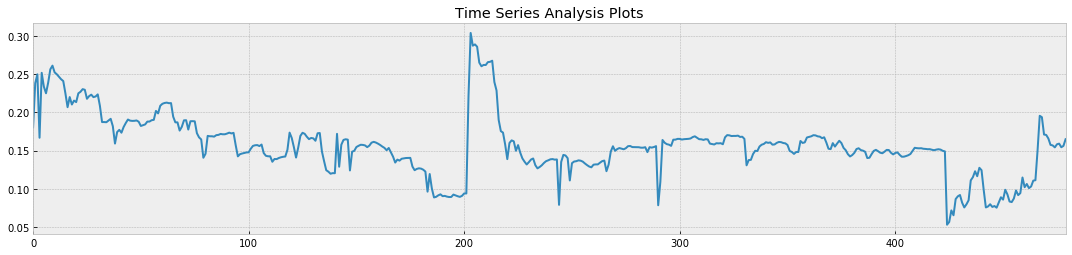

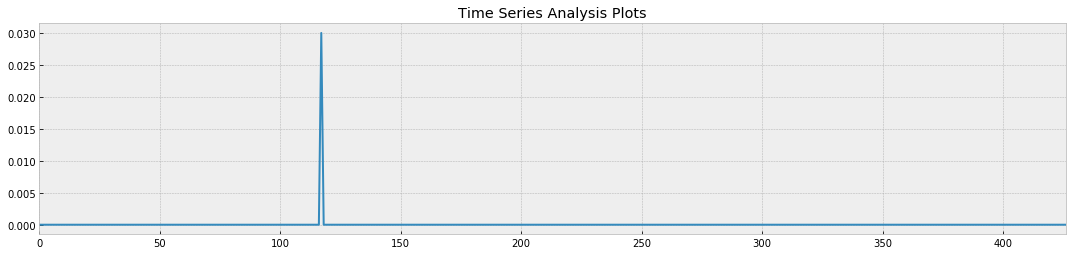

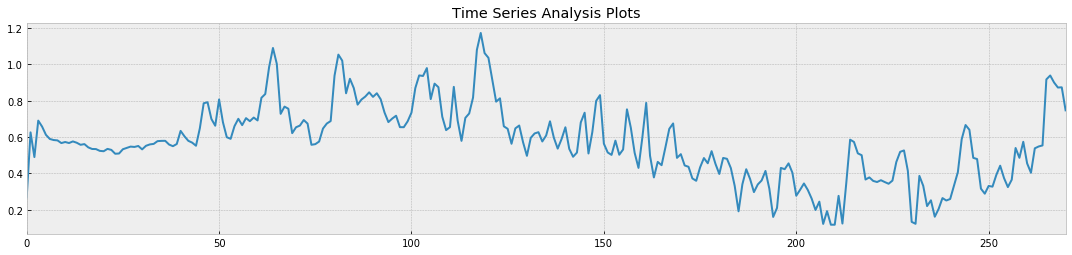

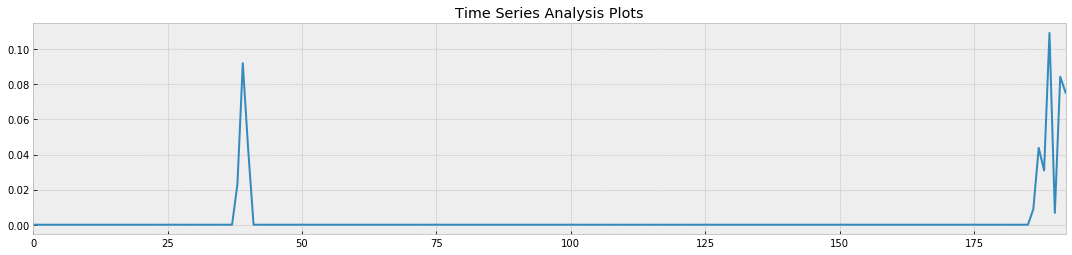

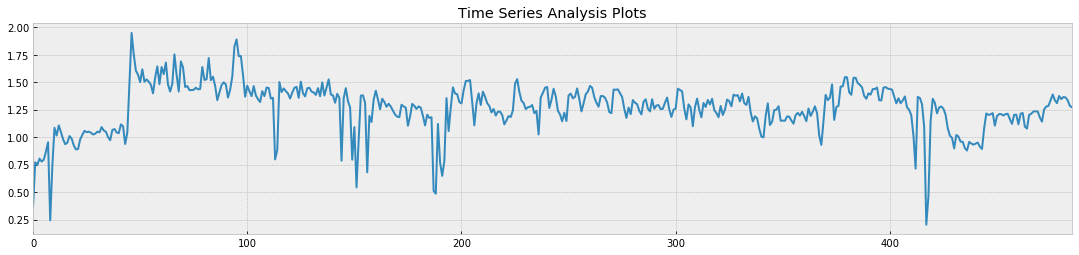

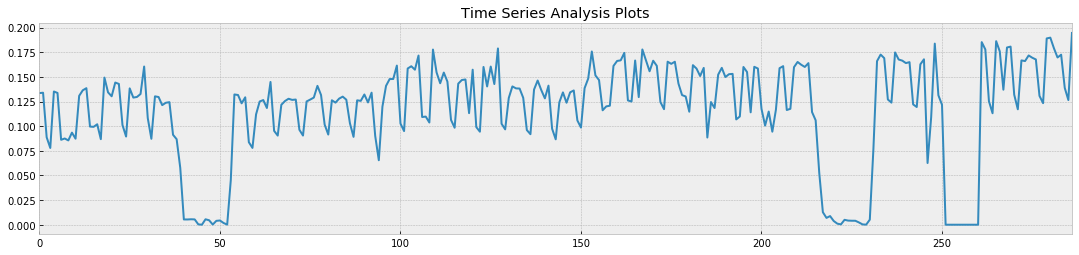

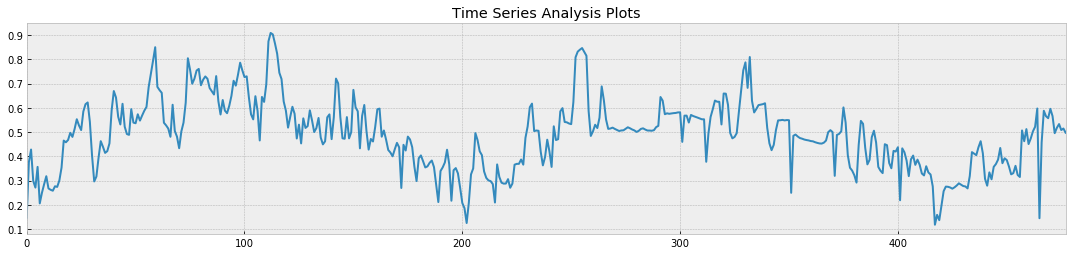

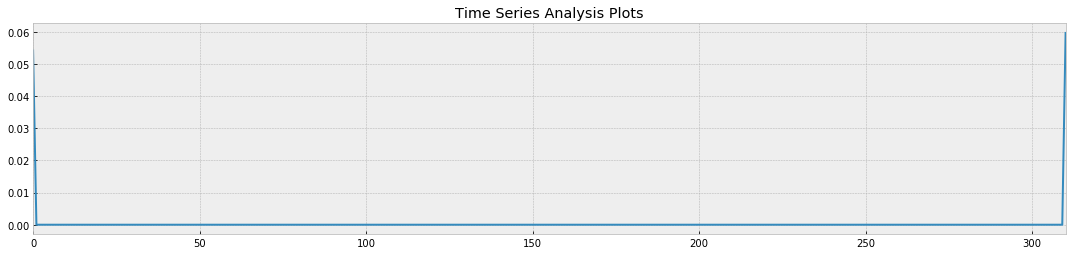

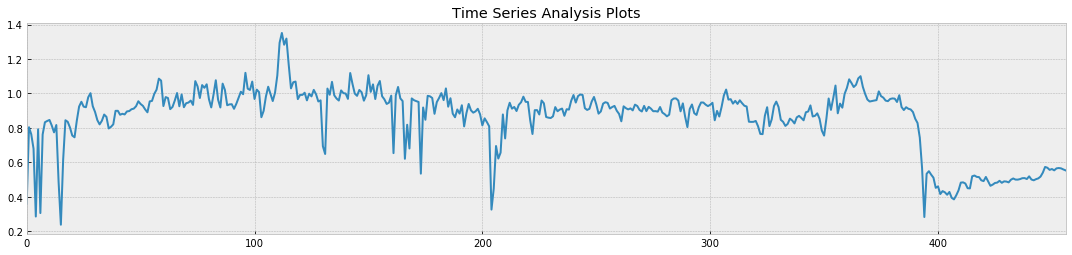

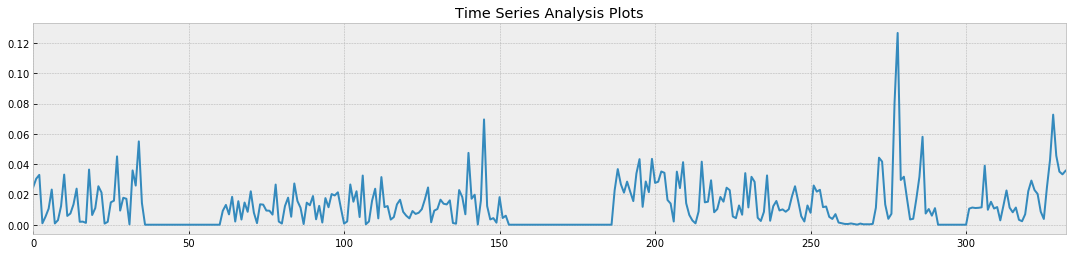

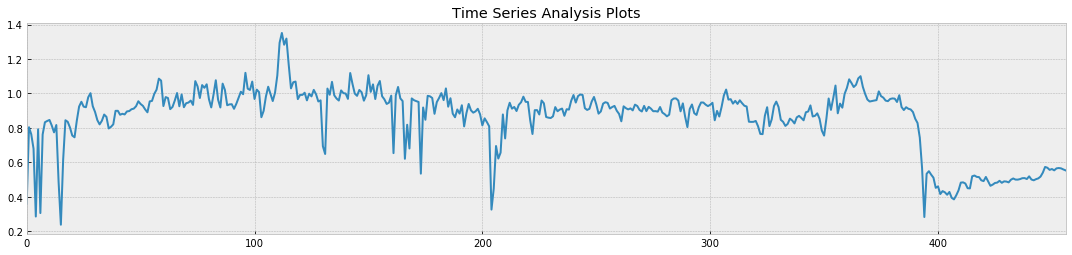

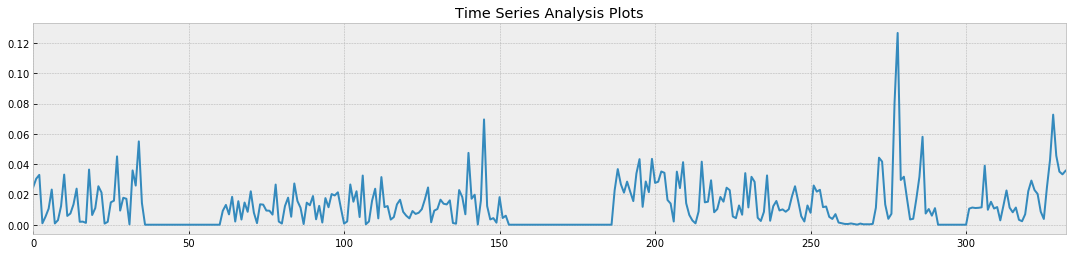

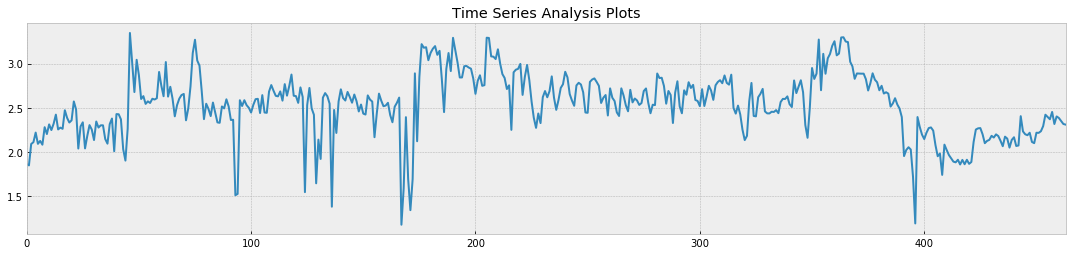

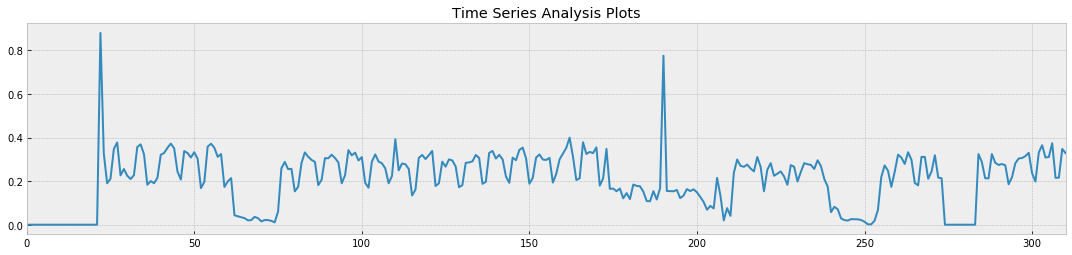

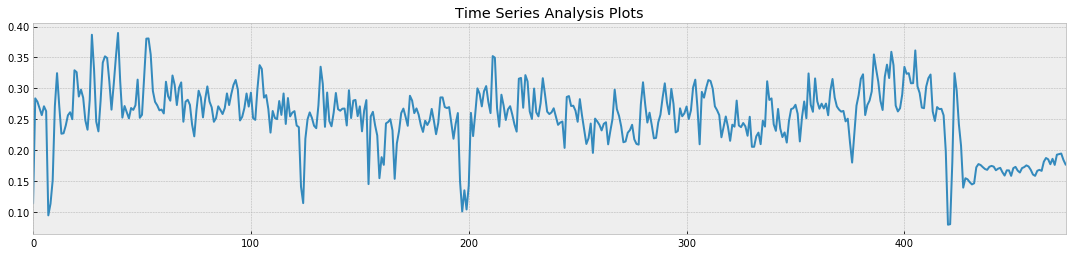

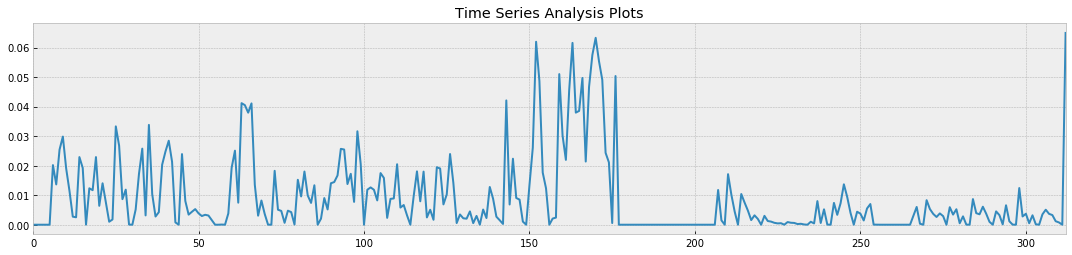

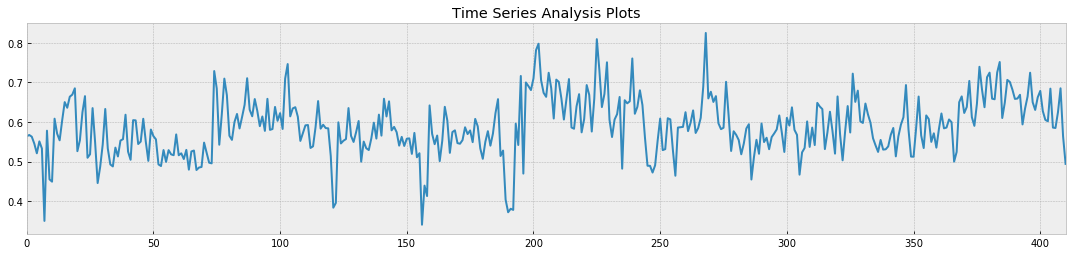

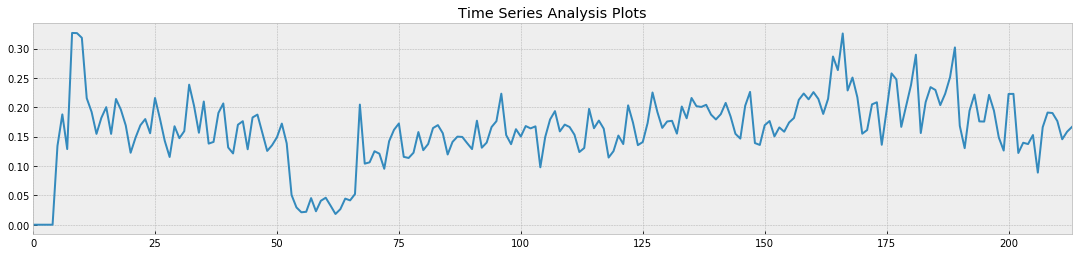

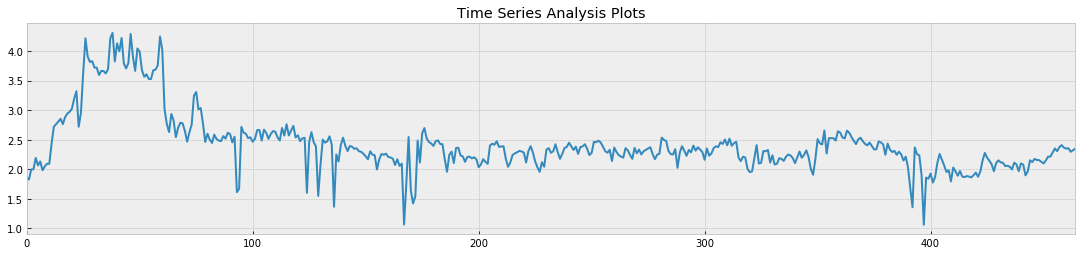

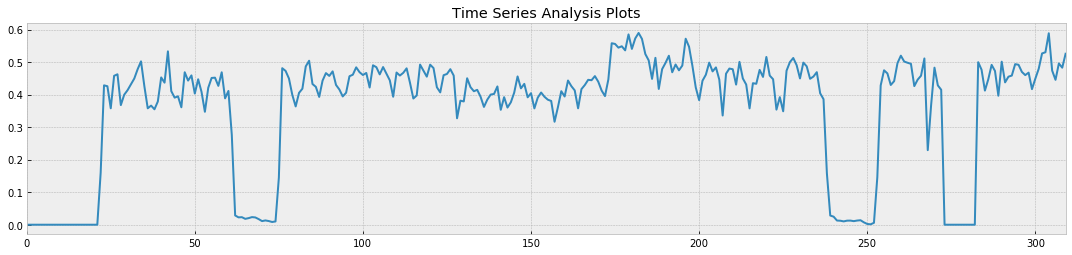

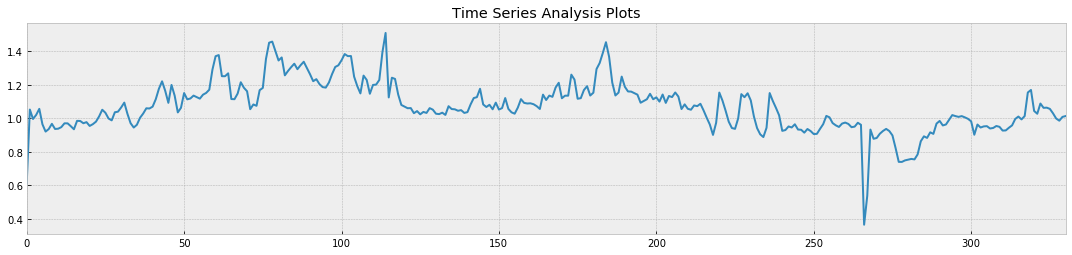

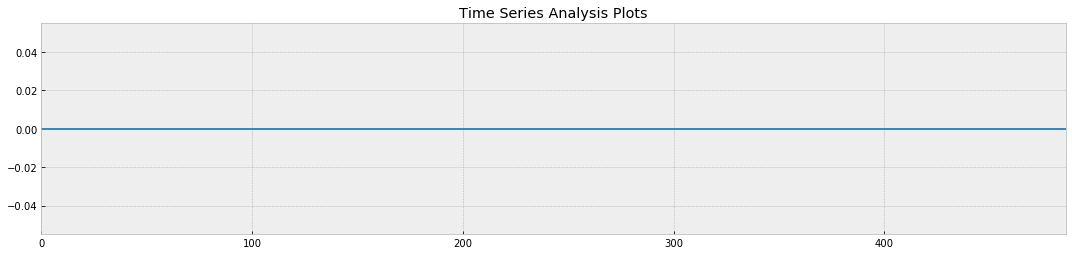

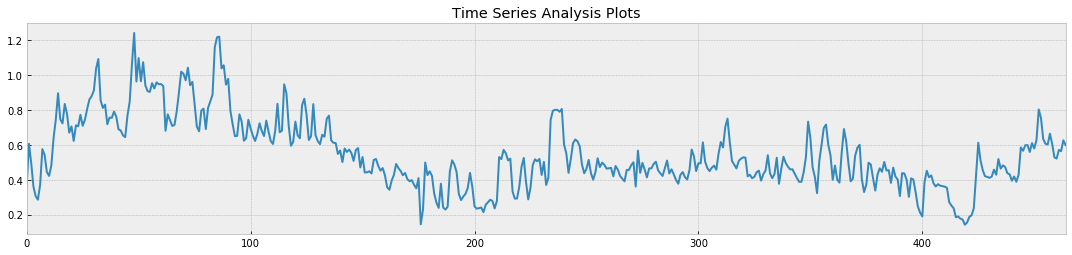

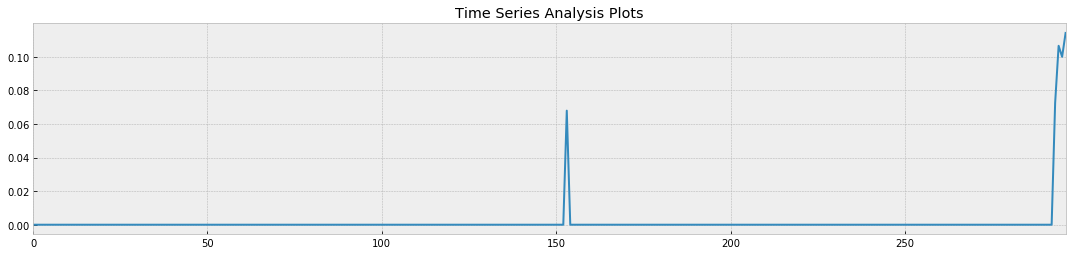

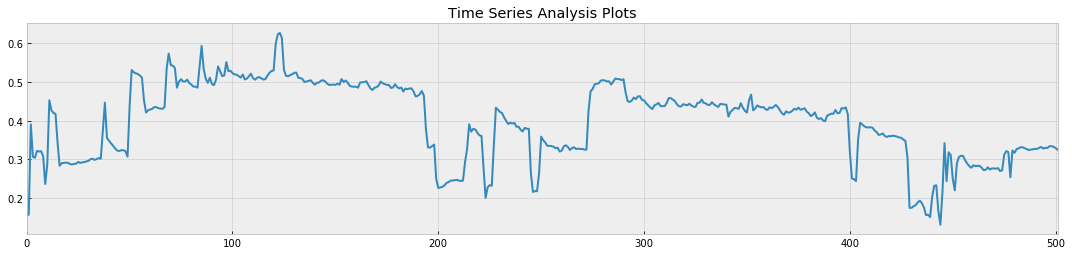

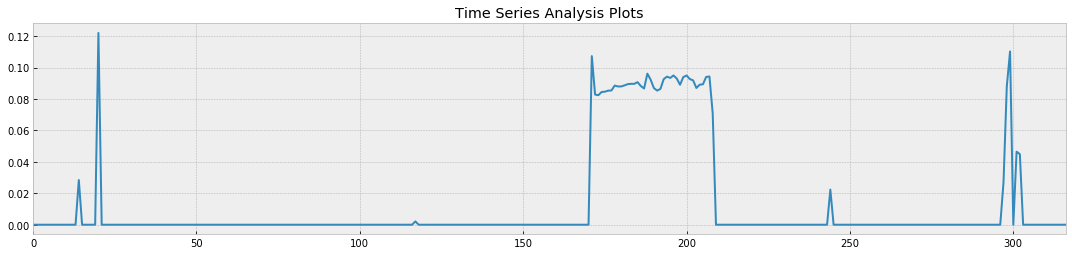

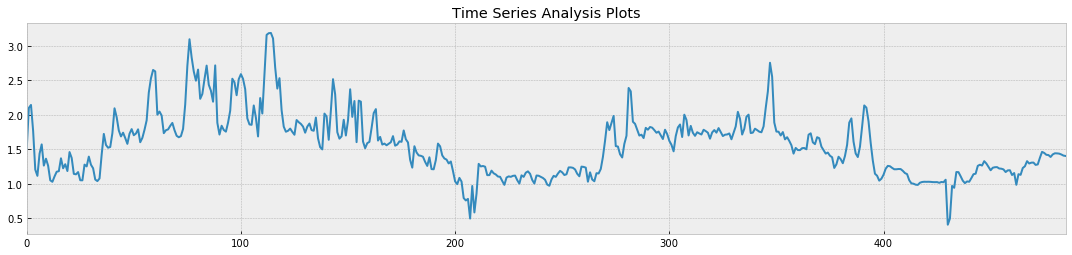

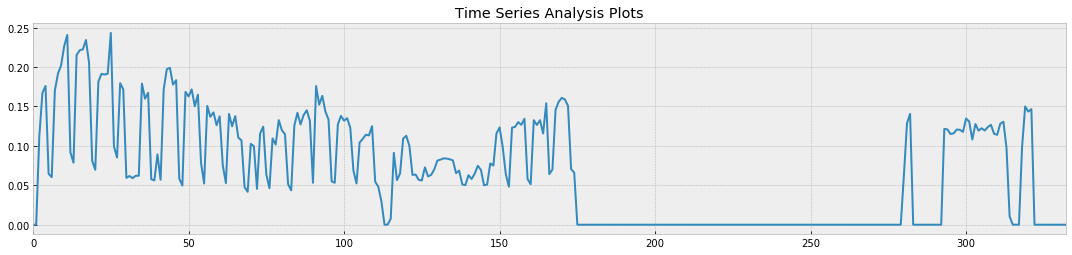

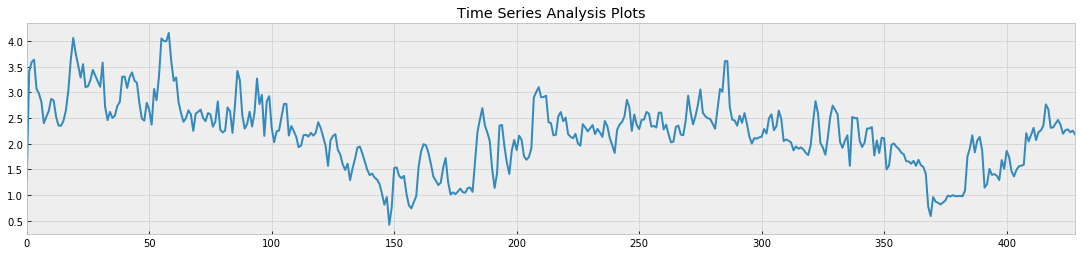

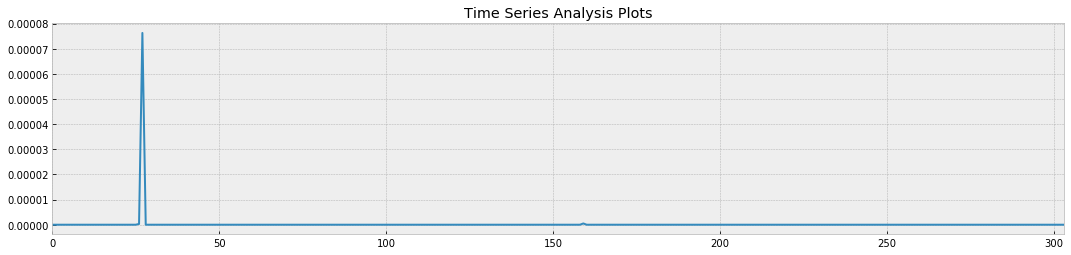

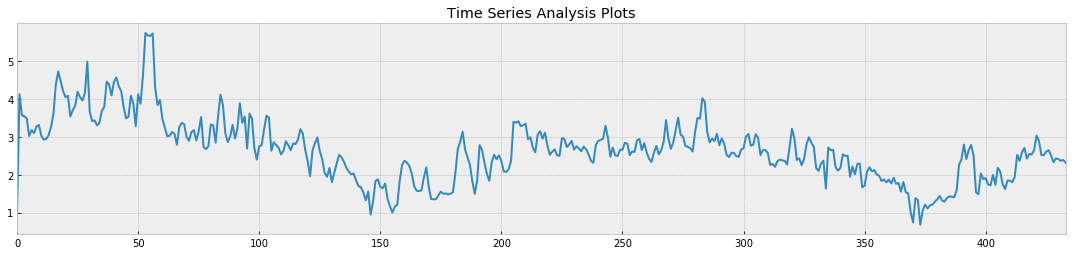

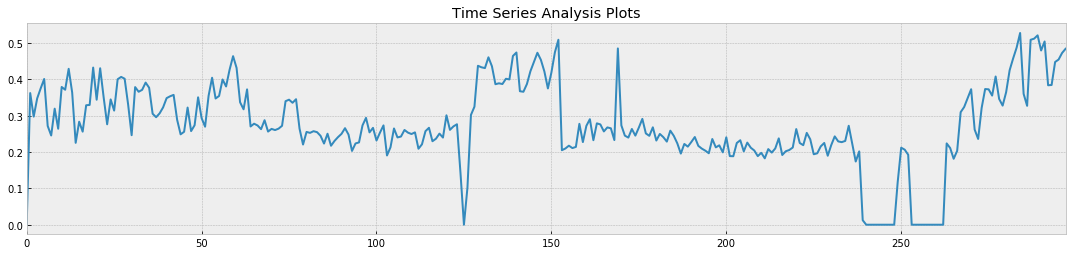

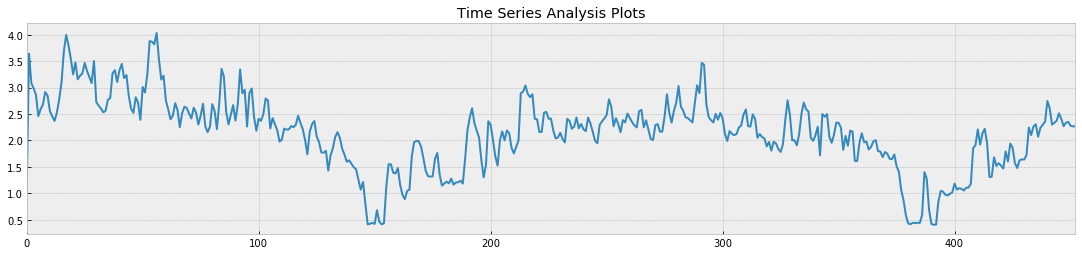

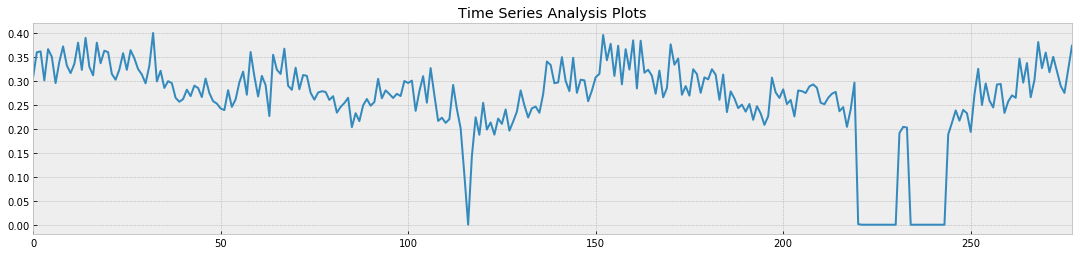

In [5]:
timeseries_water, timeseries_el, timeseries_heat = get_data(engine)

In [6]:
import math

# formula per Ecological Modeling, volume 80 (1995) pp. 87-95, called "A Model Comparison for Daylength as a Function of Latitude and Day of the Year."
# see more details - http://mathforum.org/library/drmath/view/56478.html
# Latitude in degrees, postive for northern hemisphere, negative for southern
# Day 1 = Jan 1
def day_length(day_of_year, latitude):
    P = math.asin(0.39795 * math.cos(0.2163108 + 2 * math.atan(0.9671396 * math.tan(.00860 * (day_of_year - 186)))))
    pi = math.pi
    day_light_hours = 24 - (24 / pi) * math.acos((math.sin(0.8333 * pi / 180) + math.sin(latitude * pi / 180) * math.sin(P)) / (math.cos(latitude * pi / 180) * math.cos(P)))
    return day_light_hours 


#### Данные о праздничных днях

In [120]:
df = timeseries_el[0]


holidays = db.get_holidays(engine)
exog = pd.DataFrame(index = holidays.index.values, columns=['is_holiday'])#, 'sun_time', 'temperature'
exog['is_holiday'] = 1;

dates = pd.date_range(df.index.min(), df.index.max(), freq='D')
exog = exog.reindex(dates, fill_value=0)
exog['ec_d'] = df

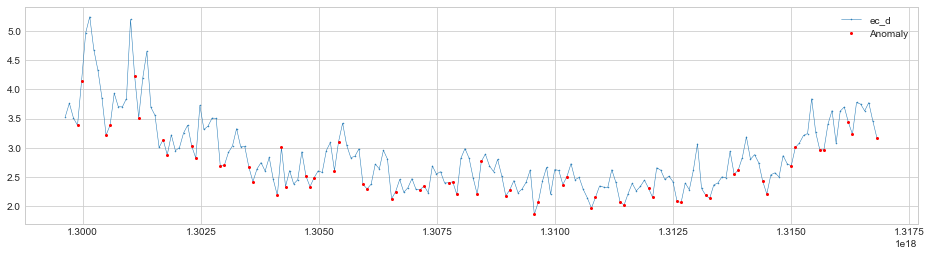

In [124]:
plot(exog.ec_d[300:500], anomaly=exog.is_holiday[300:500], ts_markersize=1, anomaly_markersize=2, anomaly_tag="marker", anomaly_color='red');


In [335]:
#fig = plt.figure(figsize=[15, 10])
#plt.plot(exog[100:300])

#### Данные о длине светового дня.
Москва - ширина 55°44′24.00″

In [12]:
print(day_length(3, 55.4424))

7.2205747100506095


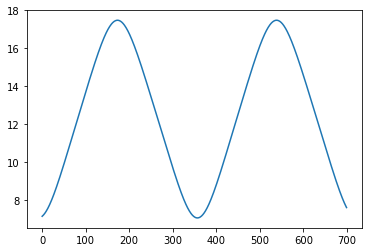

In [32]:
days_length = [day_length(i, 55.4424) for i in range(700)]
plt.plot(days_length)

In [53]:
timeseries[0].index[0].month * 30 + timeseries[0].index[0].day

163

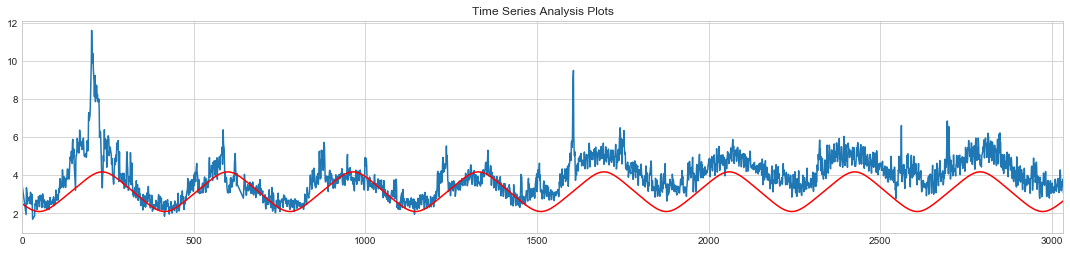

In [140]:
y = np.array(timeseries_el[0].ec_d)
y = pd.Series(y)
#with plt.style.context('bmh'):    
fig = plt.figure(figsize=[15, 10])
layout = (3, 2)
ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)   
y.plot(ax=ts_ax)
ts_ax.set_title('Time Series Analysis Plots')
day_start = timeseries_el[0].index[0].month * 30 + timeseries_el[0].index[0].day
days_length = [(-day_length(i, 55.4424) + 28) * 0.2 for i in range(day_start - 40, len(timeseries_el[0]) + day_start)]
plt.plot(days_length, color = 'red')
plt.tight_layout() 
             

#### авторегрессионные факторы

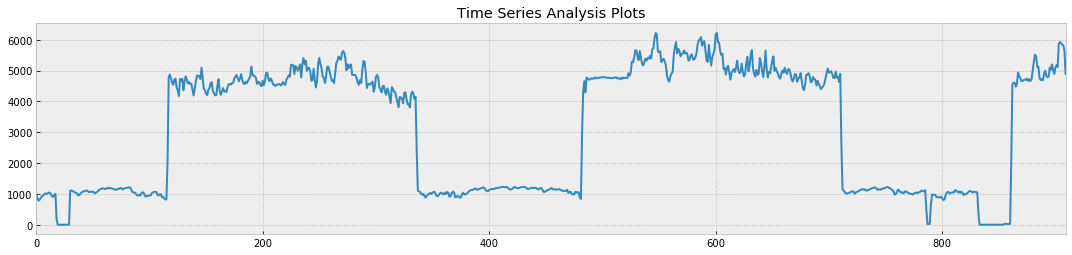

In [20]:
df = timeseries_water[1]
tsplot_only(np.array(df.ec_d))



In [21]:
#timeseries_water[0]['lag1'] = np.append(np.repeat(np.nan, 1), timeseries_water[0].ec_d[1:].values)

for i in range(1, 365):
    lag = 'lag' + str(i)
    df[lag] = np.append(np.repeat(np.nan, i), df.ec_d[:-i].values)



In [22]:
#timeseries_water[0] = timeseries_water[0].ec_d

#### экзогенные факторы

In [23]:
cols = df.columns.values
cols = np.append(cols, ['is_holiday', 'temperature', 'sun_time'])

In [24]:
holidays = db.get_holidays(engine)
exog = pd.DataFrame(index = holidays.index.values, columns=cols)#, 'sun_time', 'temperature'
exog['is_holiday'] = 1;
dates = pd.date_range(df.index.min(), df.index.max(), freq='D')
exog = exog.reindex(dates, fill_value=0)
exog[df.columns.values] = df


#### температура

In [25]:
#data = exog.ec_d.copy()
#df = pd.DataFrame(data.copy())
exog_temp = db.get_temperature(engine)

exog_temp.index = pd.to_datetime(exog_temp.index)
#exog = pd.DataFrame(index = exog_temp.index.values, columns=['temperature'])
exog_temp = exog_temp.groupby(exog_temp.index).first()
exog_temp = exog_temp.reindex(pd.date_range(exog_temp.index[0], exog_temp.index[-1], freq='D'), fill_value=0)
exog_temp = exog_temp[df.index[0]: df.index[-1]]

#df['temperature'] = np.array(exog_temp.temperature)

exog['temperature'] = np.array(exog_temp.temperature)#df['temperature']

#### длина светового дня

In [26]:
dayofyear = [(exog.index[i] - datetime.datetime(exog.index[i].year, 1, 1)).days + 1 for i in range(len(exog))]
days_length = [day_length(i, 55.4424) for i in dayofyear]
exog['sun_time'] = days_length

In [27]:
#[(exog.index[i] - datetime.datetime(exog.index[i].year, 1, 1)).days + 1 for i in range(len(exog))]

#### день недели

In [28]:
exog['weekday'] = exog.index.weekday

#### производные экзогенных факторов. Добавляем 7 лагов температуры, солнца и праздников.

In [29]:
for j in ['is_holiday', 'temperature', 'sun_time']:
    for i in range(1, 7):
        lag = 'lag' + str(i)
        exog[j + lag] = np.append(np.repeat(np.nan, i), exog[j][:-i].values)
        


#### Признак включенного отопления

In [31]:

def heating_switched_off(pred):
    cnt_8 = 0
    heat = []
    for i, row in pred.iteritems():
        fl = 0
        if (i.month >= 4 and i.month <= 9):
            fl = 1
        if (fl and row > 8):
            cnt_8 += 1 
        elif (cnt_8 < 14 or fl == 0): 
            cnt_8 = 0 
        if (i.month == 6 or i.month == 7 or i.month == 8 or i.month == 9 or cnt_8 > 14):
            heat.append(0)
            #pred.at[i] = 0
        else:
            heat.append(1)
    return heat

In [32]:
exog['heat_off'] = heating_switched_off(exog.temperature)

## Отбор признаков

### Фильтрационные. 
#### Корреляция

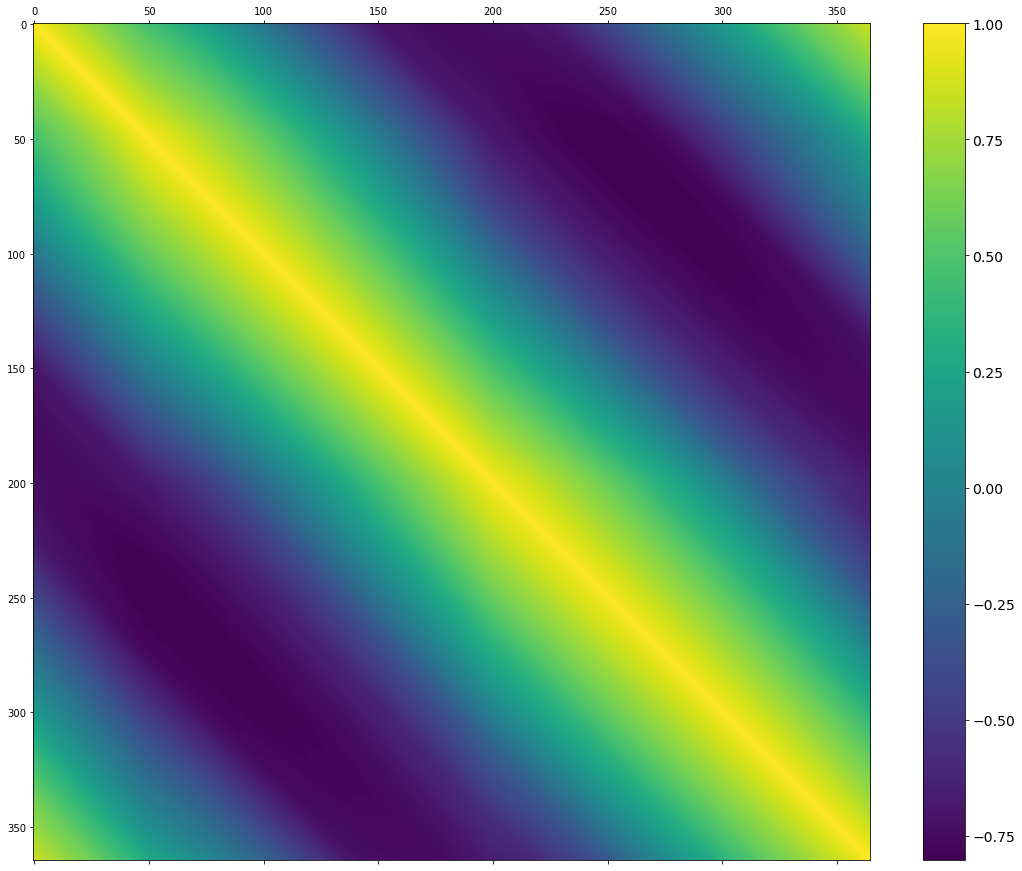

In [92]:
exog1 = exog.rename(columns={'ec_d':'target'})
columns1 = exog1.columns[:365].values
exog1 = exog1[columns1]
columns1 = ['target']
for i in range(1, 365):
    columns1.append(str(i) )
exog1.columns = columns1
corr1 = exog1.copy()
f = plt.figure(figsize=(19, 15))
plt.matshow(corr1.corr(), fignum=f.number)
#plt.xticks(range(corr1.shape[1]), corr1.columns, fontsize=11, rotation=45)
#plt.yticks(range(corr1.shape[1]), corr1.columns, fontsize=11)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16);


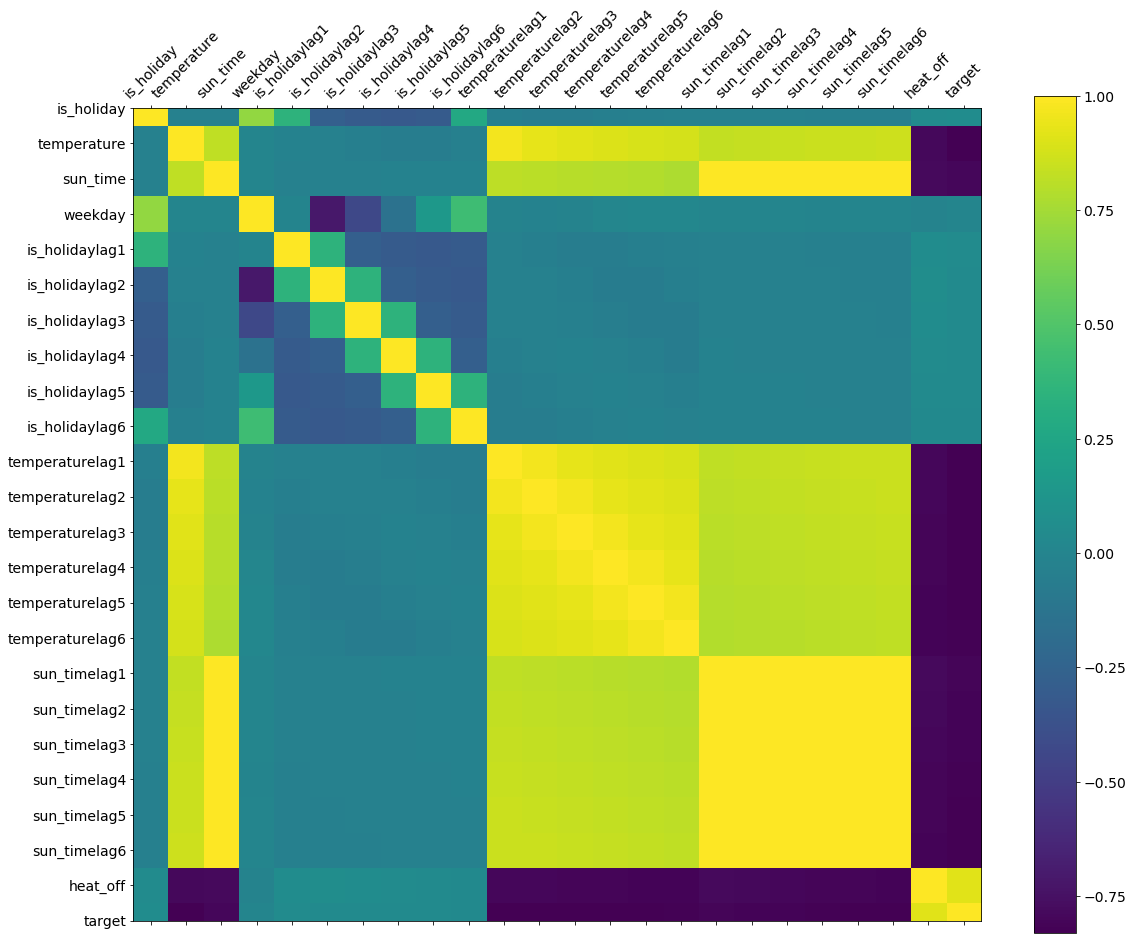

In [57]:
exog1 = exog.rename(columns={'ec_d':'target'})
columns1 = exog1.columns[365:].values
columns1 = np.append(columns1, 'target')
corr1 = exog1[columns1]
f = plt.figure(figsize=(19, 15))
plt.matshow(corr1.corr(), fignum=f.number)
plt.xticks(range(corr1.shape[1]), corr1.columns, fontsize=14, rotation=45)
plt.yticks(range(corr1.shape[1]), corr1.columns, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16);


In [94]:
cor = exog.corr()
cor.ec_d.loc[cor.ec_d > 0.9]


ec_d        1.000000
lag1        0.991701
lag2        0.978439
lag3        0.966243
lag4        0.954838
lag5        0.943069
lag6        0.931380
lag7        0.920319
lag8        0.909438
heat_off    0.918600
Name: ec_d, dtype: float64

In [97]:
np.abs(cor.ec_d).loc[np.abs(cor.ec_d) > 0.8]


ec_d               1.000000
lag1               0.991701
lag2               0.978439
lag3               0.966243
lag4               0.954838
lag5               0.943069
lag6               0.931380
lag7               0.920319
lag8               0.909438
lag9               0.898501
lag10              0.887780
lag11              0.876965
lag12              0.866110
lag13              0.855537
lag14              0.845128
lag15              0.834881
lag16              0.824632
lag17              0.814357
lag18              0.803801
lag359             0.805819
lag360             0.816416
lag361             0.827063
lag362             0.837589
lag363             0.848623
lag364             0.860574
temperature        0.826607
temperaturelag1    0.826360
temperaturelag2    0.825217
temperaturelag3    0.826247
temperaturelag4    0.825911
temperaturelag5    0.824079
temperaturelag6    0.822193
sun_timelag1       0.805444
sun_timelag2       0.810847
sun_timelag3       0.816023
sun_timelag4       0

#### Взаимная информация

In [169]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score

info = []
for i in exog.columns:
    info.append(mutual_info_score(exog[i], exog.ec_d))

In [202]:
exog_info = pd.DataFrame(data = info,  index = exog.columns.values, columns = ['ec_d'])#info,
#exog_info
np.abs(exog_info['ec_d']).loc[np.abs(exog_info['ec_d']) > 6.64]


ec_d      6.674834
lag1      6.659300
lag2      6.645057
lag77     6.642227
lag78     6.642227
            ...   
lag360    6.645849
lag361    6.645849
lag362    6.645849
lag363    6.645849
lag364    6.645849
Name: ec_d, Length: 291, dtype: float64

In [ ]:
exog1 = exog.rename(columns={'ec_d':'target'})
columns1 = exog1.columns[365:].values
columns1 = np.append(columns1, 'target')
corr1 = exog1[columns1]
f = plt.figure(figsize=(19, 15))
plt.matshow(corr1.corr(), fignum=f.number)
plt.xticks(range(corr1.shape[1]), corr1.columns, fontsize=14, rotation=45)
plt.yticks(range(corr1.shape[1]), corr1.columns, fontsize=14)

cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16);


In [158]:
def train_test_split(data, test_size=0.15):#, lag_start=5, lag_end=20

    data = pd.DataFrame(data.copy())
    #data.columns = ["ec_d"]
    data = data.dropna()
    data = data.reset_index(drop=True)
    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))
    print(len(data))
    print(test_index)
    # добавляем лаги исходного ряда в качестве признаков

    

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["ec_d"], axis=1)
    y_train = data.loc[:test_index]["ec_d"]
    X_test = data.loc[test_index:].drop(["ec_d"], axis=1)
    y_test = data.loc[test_index:]["ec_d"]

    return X_train, X_test, y_train, y_test

In [110]:
X_train, X_test, y_train, y_test = train_test_split(exog, 0.15)


546
464


### Встроенные методы
#### линейная регрессия

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
#%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler


In [120]:
X_train.columns

Index(['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9',
       'lag10',
       ...
       'temperaturelag4', 'temperaturelag5', 'temperaturelag6', 'sun_timelag1',
       'sun_timelag2', 'sun_timelag3', 'sun_timelag4', 'sun_timelag5',
       'sun_timelag6', 'heat_off'],
      dtype='object', length=387)

In [130]:
scaler = StandardScaler()
scaler.fit(X_train.fillna(0))

sel_ = SelectFromModel(Lasso(), max_features = 10)
sel_.fit(scaler.transform(X_train.fillna(0)), y_train)
#sel_.get_support()


SelectFromModel(estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                                max_iter=1000, normalize=False, positive=False,
                                precompute=False, random_state=None,
                                selection='cyclic', tol=0.0001,
                                warm_start=False),
                max_features=10, norm_order=1, prefit=False, threshold=None)

In [131]:
feature_score = pd.DataFrame(data = sel_.get_support().astype(int), columns = ['is_important'])
feature_score.index = X_train.columns.values
feature_top = feature_score.loc[feature_score['is_important'] > 0]['is_important'].to_dict()

In [132]:
feature_top

{'lag1': 1,
 'lag2': 1,
 'lag83': 1,
 'lag146': 1,
 'lag228': 1,
 'lag229': 1,
 'lag230': 1,
 'lag364': 1,
 'temperature': 1,
 'temperaturelag1': 1}

In [423]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

разделение на тест трейн

In [588]:
def train_test_split(data, test_size=0.15):

    data = pd.DataFrame(data.copy())
    #data.columns = ["ec_d"]
    data = data.dropna()
    data = data.reset_index(drop=True)
    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))
    print(len(data))
    print(test_index)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["ec_d"], axis=1)
    y_train = data.loc[:test_index]["ec_d"]
    X_test = data.loc[test_index:].drop(["ec_d"], axis=1)
    y_test = data.loc[test_index:]["ec_d"]

    return X_train, X_test, y_train, y_test

###  xgboost

In [160]:


def XGB_forecast(data, test_size=0.15, scale=1.96, feature_top_10):

    # исходные данные
    X_train, X_test, y_train, y_test = train_test_split(data,  test_size)#lag_start, lag_end,
    #print(X_train)
    #print(X_test)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'objective': 'reg:squarederror',#'objective': 'reg:linear',
        'booster':'gbtree'#'booster':'gblinear'
    }
    trees = 100

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())
    
    plot_importance(bst, max_num_features=10)
    feature_score = bst.get_score()
    feature_top_10 = dict(sorted(feature_score.items(), key=operator.itemgetter(1), reverse=True)[:feature_top_10])

    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]
    print('deviation', deviation)
    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    #print(prediction_test, y_test)
    #print('aaaa')
    plt.title("XGBoost Mean absolute error {} ".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()
    return feature_top_10

546
464
{'lag1': 142, 'lag2': 31, 'lag3': 26, 'lag4': 23, 'temperature': 22, 'lag108': 18, 'lag5': 12, 'lag331': 9, 'lag6': 9, 'temperaturelag1': 8}
deviation 267.6482918


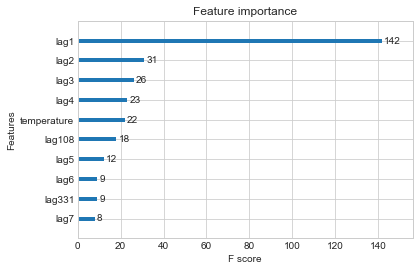

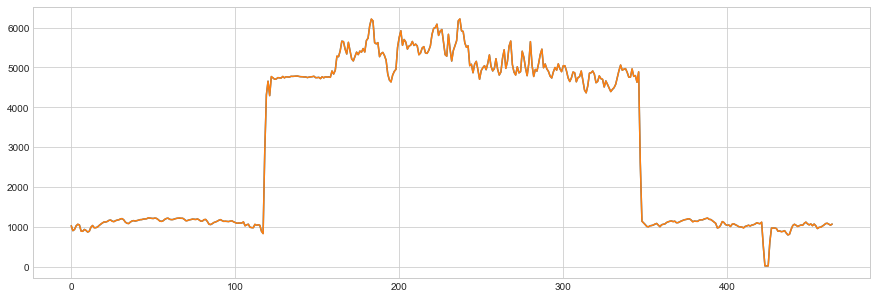

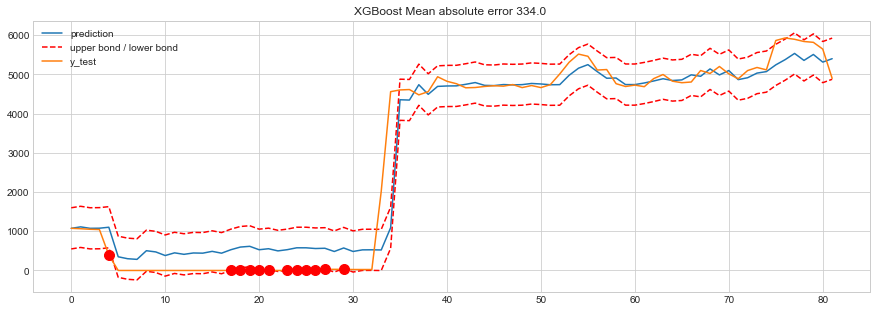

In [596]:
XGB_forecast(exog)

Оберточные методы

https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/

In [162]:
import statsmodels.api as sm
def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

forward_selection(X_train, y_train, significance_level=0.05)


['lag1',
 'lag364',
 'lag2',
 'lag3',
 'temperature',
 'temperaturelag1',
 'temperaturelag2',
 'temperaturelag4',
 'temperaturelag3',
 'lag227',
 'lag230',
 'lag211',
 'lag229',
 'lag112',
 'lag300',
 'lag79',
 'lag146',
 'lag148',
 'lag331']

In [163]:
def backward_elimination(data, target,significance_level = 0.0000):
    features = data.columns.tolist()
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
    return features
backward_elimination(X_train, y_train)


[]

### Проверка на Стабильность

In [577]:
np.abs(cor.ec_d)

ec_d            1.000000
lag1            0.991701
lag2            0.978439
lag3            0.966243
lag4            0.954838
                  ...   
sun_timelag2    0.810847
sun_timelag3    0.816023
sun_timelag4    0.820994
sun_timelag5    0.825761
sun_timelag6    0.830323
Name: ec_d, Length: 387, dtype: float64

In [167]:
def cross_validation_stability(X_train, y_train, number_folds, model_type = 'xgb', max_features = 10):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    
    z = []
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        #X_testFold = X[(index + 1):]
        #y_testFold = y[(index + 1):]
    
        ############ для xgb
        if (model_type == 'xgb'):
            
            dtrain = xgb.DMatrix(X_trainFolds, label=y_trainFolds)
            #dtest = xgb.DMatrix(X_testFold)
            params = {
                'objective': 'reg:squarederror',
                'booster':'gbtree'
            }
            trees = 100
            cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)
            bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

            feature_score = bst.get_score()
            feature_top = dict(sorted(feature_score.items(), key=operator.itemgetter(1), reverse=True)[:max_features])
        ########### для корреляции
        if (model_type == 'mutual_info'):
            X = X_trainFolds.copy()
            X['ec_d'] = y_trainFolds
            cor = X.corr()
            feature_top = dict(sorted(np.abs(cor.ec_d).to_dict().items(), key=operator.itemgetter(1), reverse=True)[:max_features])
        
        
        
        ########### для корреляции
        if (model_type == 'corr'):
            X = X_trainFolds.copy()
            X['ec_d'] = y_trainFolds
            cor = X.corr()
            feature_top = dict(sorted(np.abs(cor.ec_d).to_dict().items(), key=operator.itemgetter(1), reverse=True)[:max_features])
        
        
        
        ###############
        if (model_type == 'fw'):
            feature_top = forward_selection(X_trainFolds, y_trainFolds, significance_level=0.05)
        
        ###########
        if (model_type == 'lasso'):
            scaler = StandardScaler()
            scaler.fit(X_trainFolds.fillna(0))

            sel_ = SelectFromModel(Lasso(), max_features = max_features)
            sel_.fit(scaler.transform(X_trainFolds), y_trainFolds)
            feature_score = pd.DataFrame(data = sel_.get_support().astype(int), columns = ['is_important'])
            feature_score.index = X_train.columns.values
            feature_top = feature_score.loc[feature_score['is_important'] > 0]['is_important'].to_dict()
        ############
        if (model_type == 'ansimble'):
            X_y = X_trainFolds.copy()     
            X_y['ec_d'] = y_trainFolds
            feature_top = ansimble(X_y)
        
        ############
        new_z = []
        for j in X_train.columns:
            if j in feature_top:
                new_z.append(1)
            else:
                new_z.append(0)
        z.append(new_z)
    Z = pd.DataFrame(data = z, columns = X_train.columns)
    
    d = Z.shape[1]
    kbar = Z.sum(1).mean();
    stability = 1 - Z.var(0, ddof=1).mean() / ((kbar/d)*(1-kbar/d))
    return stability


Size train set: (465, 387)
Size of each fold: 46

Splitting the first 2 chunks at 1/2
Size of train + test: (92, 387)
46
39
46
39
deviation 29.6534141
stability 0.1283783783783784

Splitting the first 3 chunks at 2/3
Size of train + test: (138, 387)
92
78
92
78
deviation 28.432591599999995
stability 0.22503943964157258

Splitting the first 4 chunks at 3/4
Size of train + test: (184, 387)
138
117
138
117
deviation 25.834496100000003
stability 0.19076511723570555

Splitting the first 5 chunks at 4/5
Size of train + test: (230, 387)
184
156
184
156
deviation 138.5645863
stability 0.320662581386442

Splitting the first 6 chunks at 5/6
Size of train + test: (276, 387)
230
195
230
195
deviation 167.3549453
stability 0.3541528239202657

Splitting the first 7 chunks at 6/7
Size of train + test: (322, 387)
276
234
276
234
deviation 158.28846579999998
stability 0.23649939736014347

Splitting the first 8 chunks at 7/8
Size of train + test: (368, 387)
322
273
322
273
deviation 175.2547447
stabilit

0.4378836082180716

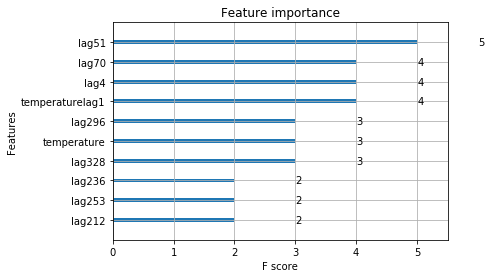

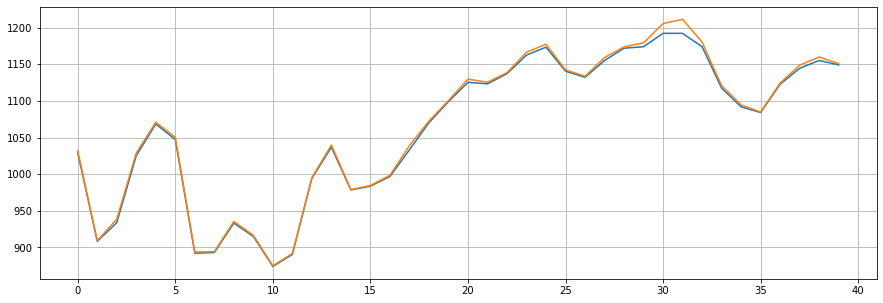

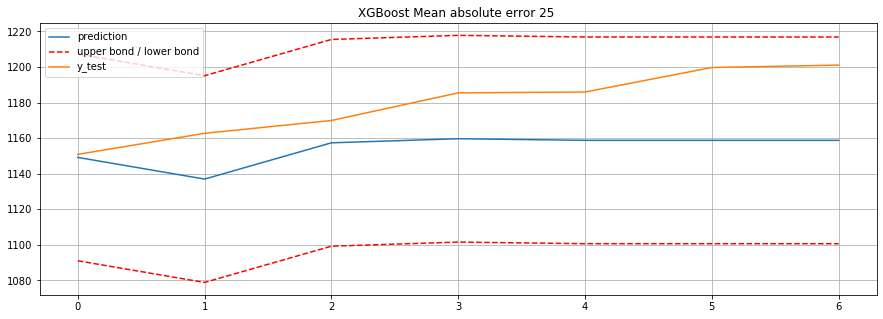

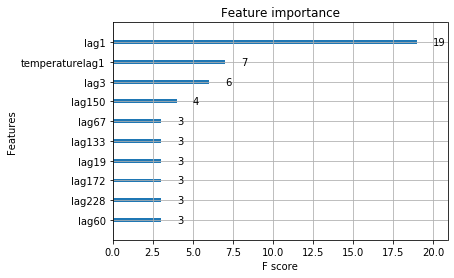

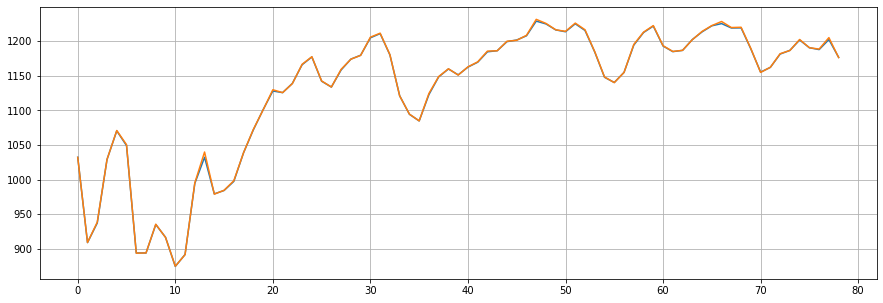

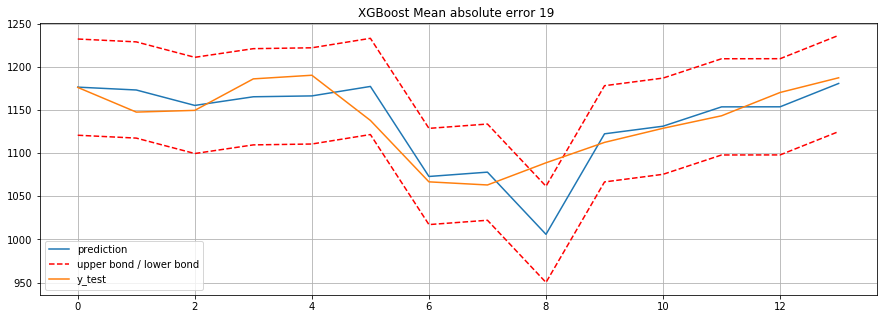

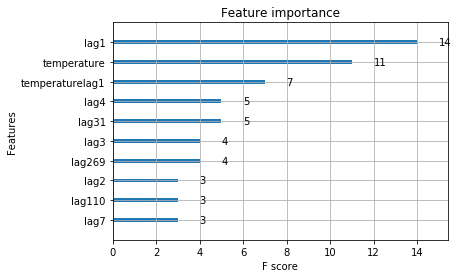

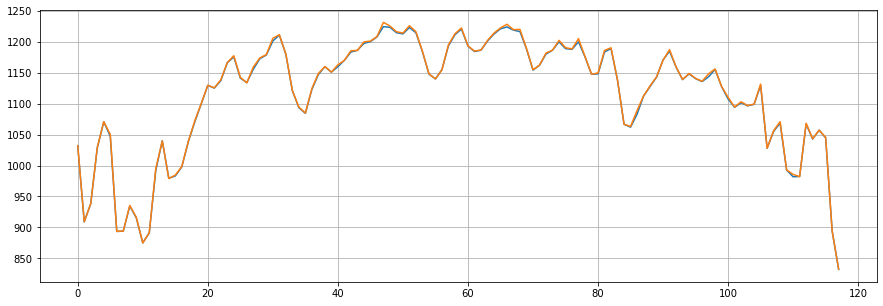

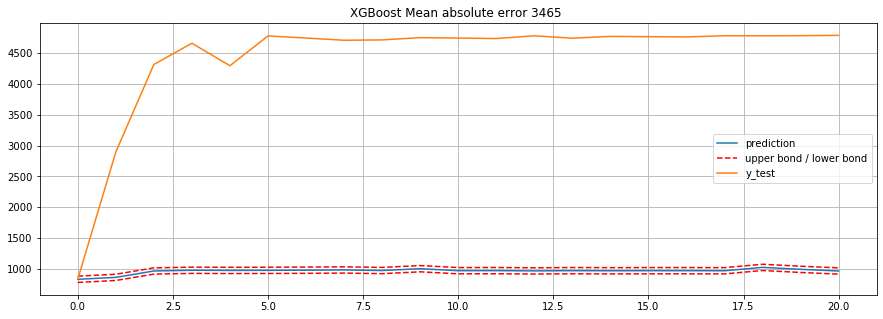

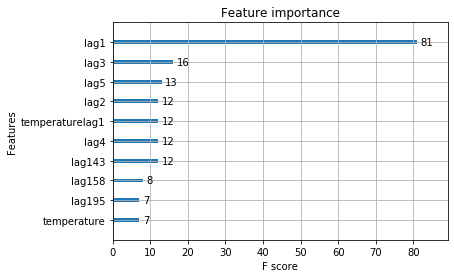

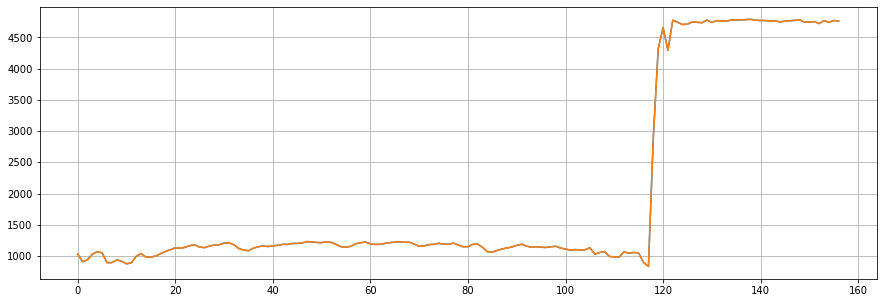

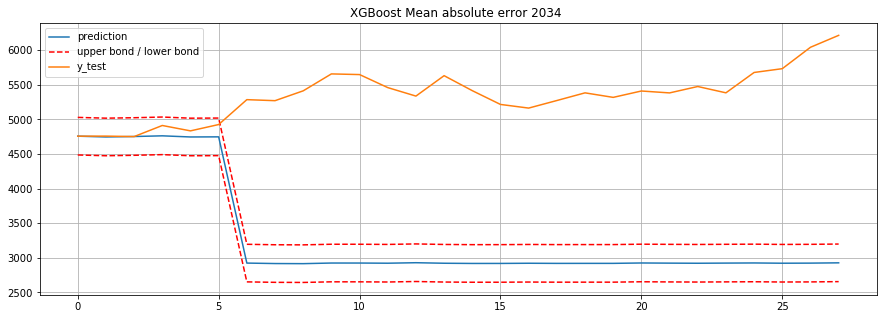

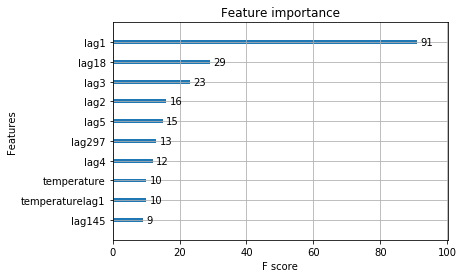

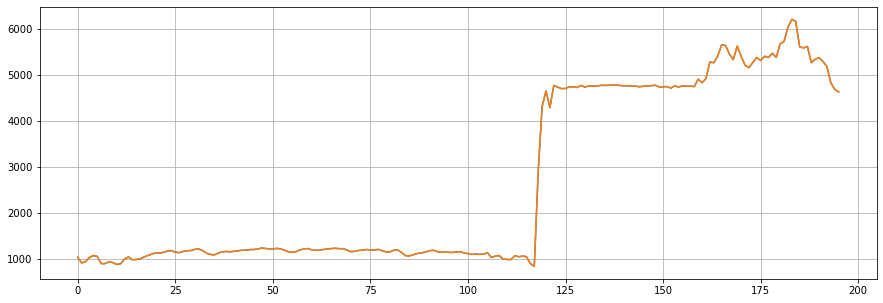

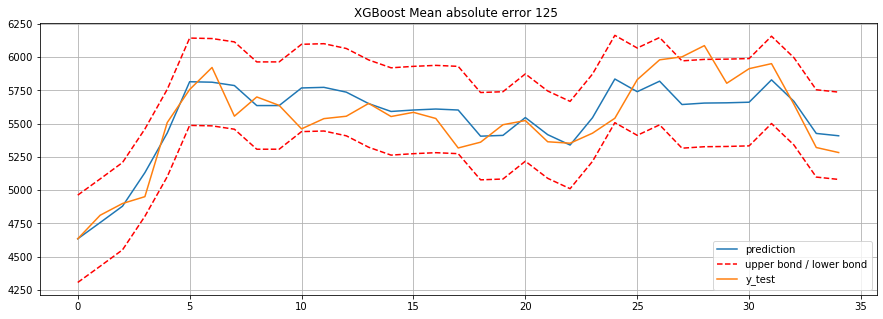

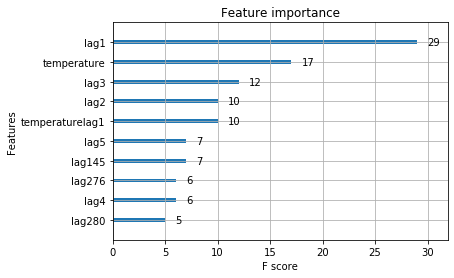

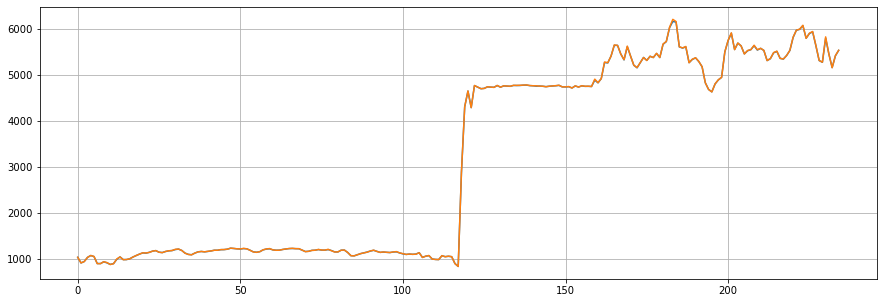

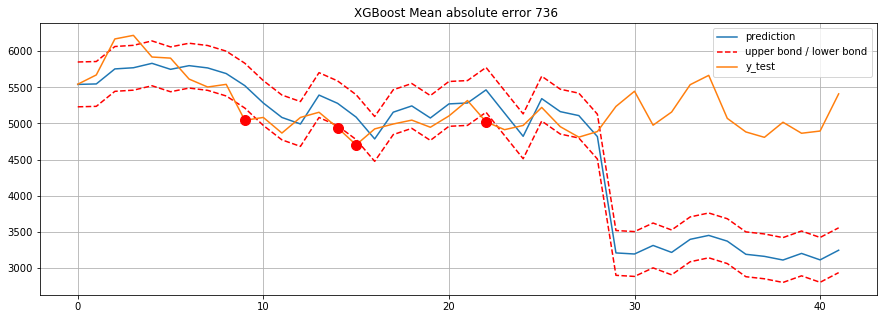

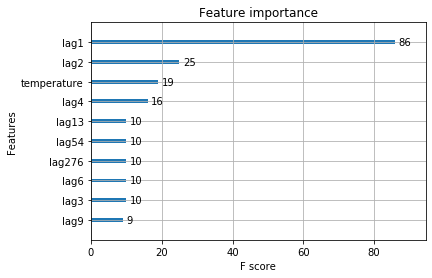

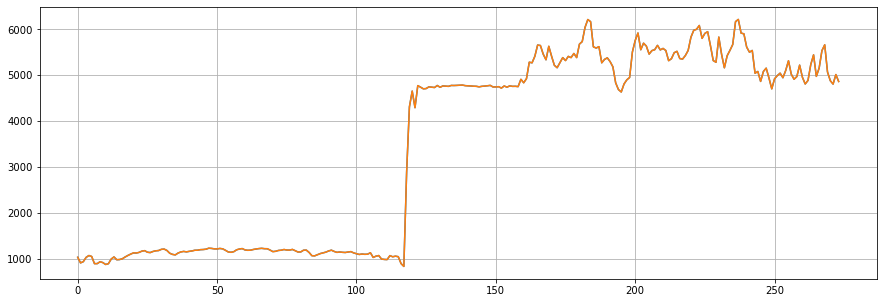

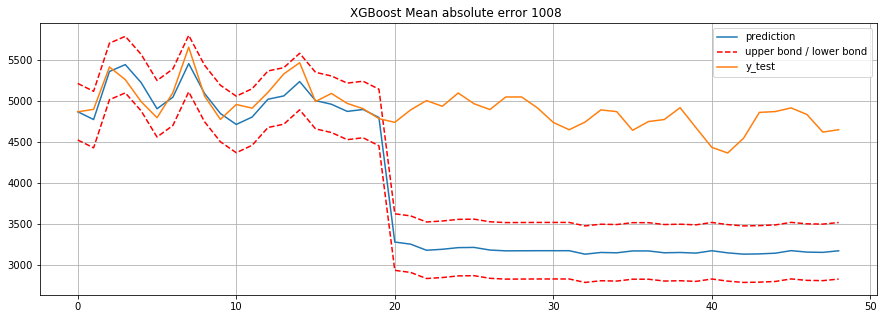

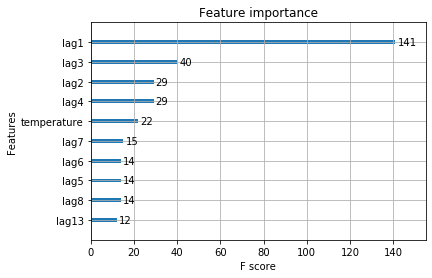

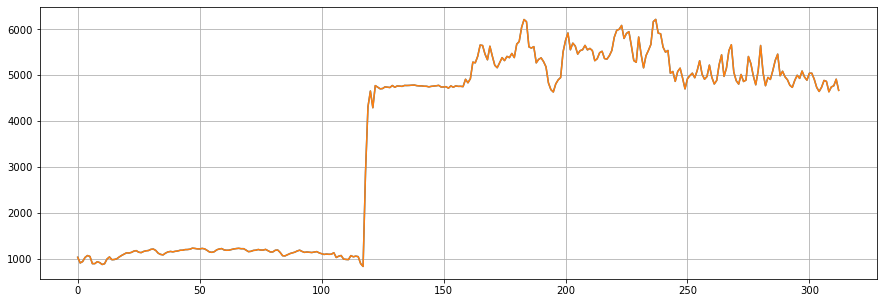

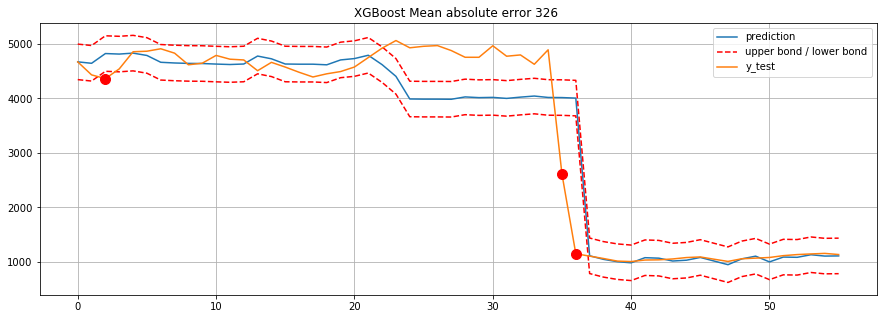

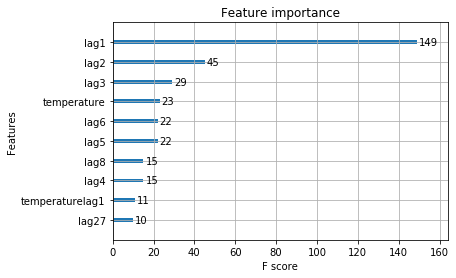

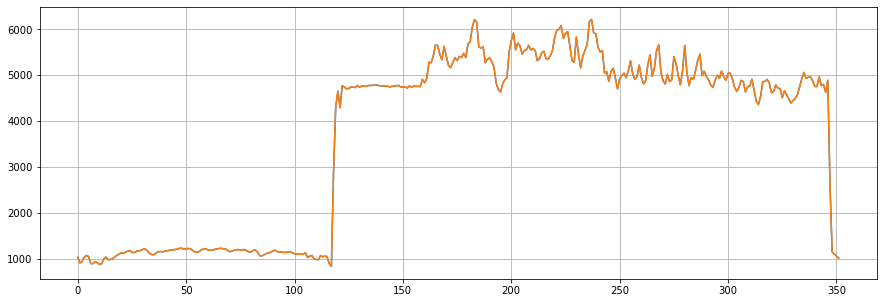

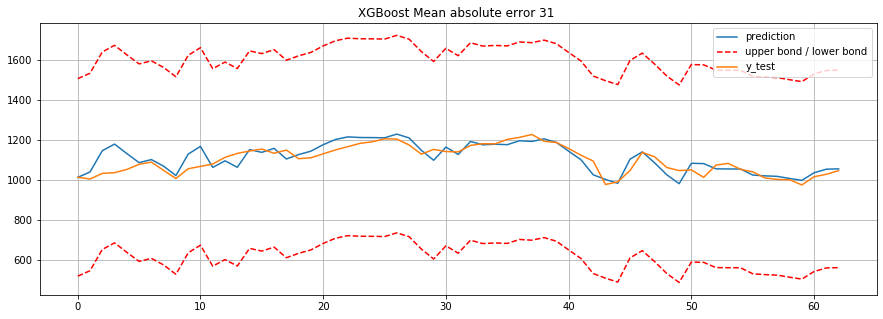

In [168]:
cross_validation_stability(X_train, y_train, 10, model_type = 'ansimble', max_features = 5)


In [145]:
cross_validation_stability(X_train, y_train, 10, model_type = 'lasso', max_features = 6)


Size train set: (465, 387)
Size of each fold: 46

Splitting the first 2 chunks at 1/2
Size of train + test: (92, 387)

Splitting the first 3 chunks at 2/3
Size of train + test: (138, 387)

Splitting the first 4 chunks at 3/4
Size of train + test: (184, 387)

Splitting the first 5 chunks at 4/5
Size of train + test: (230, 387)

Splitting the first 6 chunks at 5/6
Size of train + test: (276, 387)

Splitting the first 7 chunks at 6/7
Size of train + test: (322, 387)

Splitting the first 8 chunks at 7/8
Size of train + test: (368, 387)

Splitting the first 9 chunks at 8/9
Size of train + test: (414, 387)

Splitting the first 10 chunks at 9/10
Size of train + test: (460, 387)


0.3745625546806649

In [148]:
cross_validation_stability(X_train, y_train, 10, model_type = 'corr', max_features = 10)

Size train set: (465, 387)
Size of each fold: 46

Splitting the first 2 chunks at 1/2
Size of train + test: (92, 387)

Splitting the first 3 chunks at 2/3
Size of train + test: (138, 387)

Splitting the first 4 chunks at 3/4
Size of train + test: (184, 387)

Splitting the first 5 chunks at 4/5
Size of train + test: (230, 387)

Splitting the first 6 chunks at 5/6
Size of train + test: (276, 387)

Splitting the first 7 chunks at 6/7
Size of train + test: (322, 387)

Splitting the first 8 chunks at 7/8
Size of train + test: (368, 387)

Splitting the first 9 chunks at 8/9
Size of train + test: (414, 387)

Splitting the first 10 chunks at 9/10
Size of train + test: (460, 387)


0.4569383416017009

In [154]:
cross_validation_stability(X_train, y_train, 10, model_type='xgb', max_features = 6)

Size train set: (465, 387)
Size of each fold: 46

Splitting the first 2 chunks at 1/2
Size of train + test: (92, 387)

Splitting the first 3 chunks at 2/3
Size of train + test: (138, 387)

Splitting the first 4 chunks at 3/4
Size of train + test: (184, 387)

Splitting the first 5 chunks at 4/5
Size of train + test: (230, 387)

Splitting the first 6 chunks at 5/6
Size of train + test: (276, 387)

Splitting the first 7 chunks at 6/7
Size of train + test: (322, 387)

Splitting the first 8 chunks at 7/8
Size of train + test: (368, 387)

Splitting the first 9 chunks at 8/9
Size of train + test: (414, 387)

Splitting the first 10 chunks at 9/10
Size of train + test: (460, 387)


0.506233595800525

In [155]:
#Отбираем ряды с кросс валидацией Z = [...] # Mxd numpy array
#cross_validation(X_train, y_train, number_folds, model, metrics)

        if (model_type == 'xgb'):
            
            dtrain = xgb.DMatrix(X_trainFolds, label=y_trainFolds)
            #dtest = xgb.DMatrix(X_testFold)
            params = {
                'objective': 'reg:squarederror',
                'booster':'gbtree'
            }
            trees = 100
            cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)
            bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

            feature_score = bst.get_score()
            feature_top = dict(sorted(feature_score.items(), key=operator.itemgetter(1), reverse=True)[:max_features])
        
        

#### Ансамбль

546
464
546
464
deviation 270.5438263
stability 0.3836666666666666


array(['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag146', 'lag229',
       'lag230', 'lag331', 'lag364', 'temperature', 'temperaturelag1'],
      dtype=object)

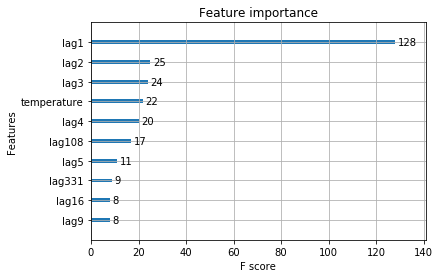

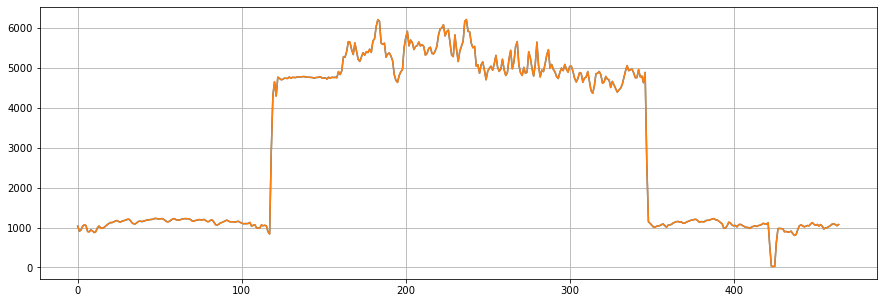

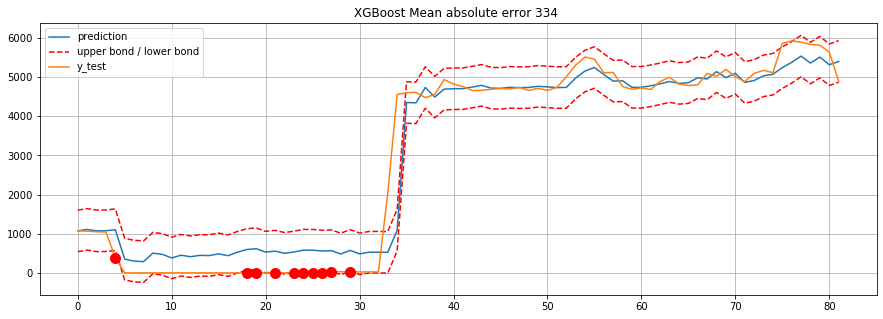

In [166]:
def ansimble(exog, max_features = 10):
    Z = []
    X_train, X_test, y_train, y_test = train_test_split(exog, 0.15)
    #X_y_train = X_train.copy()
    #X_y_train['ec_d'] = y_train

    ### xgb
    Z.append(XGB_forecast(exog))
    ### corr
    cor = exog.corr()
    feature_corr = dict(sorted(np.abs(cor.ec_d).to_dict().items(), key=operator.itemgetter(1), reverse=True)[:max_features])
    Z.append(feature_corr)

    ### forward
    feature_fw = forward_selection(X_train, y_train, significance_level=0.05)
    Z.append(feature_fw)

    ### lasso
    scaler = StandardScaler()
    scaler.fit(X_train.fillna(0))

    sel_ = SelectFromModel(Lasso(), max_features = max_features)
    sel_.fit(scaler.transform(X_train), y_train)
    feature_score = pd.DataFrame(data = sel_.get_support().astype(int), columns = ['is_important'])
    feature_score.index = X_train.columns.values
    feature_lasso = feature_score.loc[feature_score['is_important'] > 0]['is_important'].to_dict()

    Z.append(feature_lasso)

    #### 
    features = []

    for z in Z:
        new_z = []
        for j in X_train.columns:
            if j in z:
                new_z.append(1)
            else:
                new_z.append(0)
        features.append(new_z)
    features = pd.DataFrame(features, columns = X_train.columns)
    features_ = features.columns[features.sum() >= len(Z) / 2].values


    d = features.shape[1]
    kbar = features.sum(1).mean();
    stability = 1 - features.var(0, ddof=1).mean() / ((kbar/d)*(1-kbar/d))
    print('stability', stability)
    return features_

ansimble(exog)

In [637]:
features.columns[features.sum() >= len(Z) / 2].values

array(['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag79',
       'lag112', 'lag146', 'lag211', 'lag229', 'lag230', 'lag300',
       'lag331', 'lag364', 'temperature', 'temperaturelag1',
       'temperaturelag3', 'temperaturelag4'], dtype=object)

In [626]:
features = pd.DataFrame(features, columns = X_train.columns)

In [634]:
features.columns[features.sum() >= 2]

Index(['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag79',
       'lag112', 'lag146', 'lag211', 'lag229', 'lag230', 'lag300', 'lag331',
       'lag364', 'temperature', 'temperaturelag1', 'temperaturelag3',
       'temperaturelag4'],
      dtype='object')

### кросс валидация

In [267]:
def cross_validation(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()
#https://www.pvsm.ru/python/253543